In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

In [2]:
sales = pd.read_csv(
    "SalesFINAL12312016.csv",
    parse_dates=["SalesDate"],
    dtype={
        "InventoryId": str,
        "Store": str,
        "Brand": str,
        "Description": str,
        "Size": str,
        "SalesQuantity": float,
        "SalesDollars": float,
        "SalesPrice": float,
        "Volume": float,
        "Classification": str,
        "ExciseTax": float,
        "VendorNo": str,
        "VendorName": str
    }
)

purchases = pd.read_csv(
    "PurchasesFINAL12312016.csv",
    parse_dates=["PODate", "ReceivingDate", "InvoiceDate", "PayDate"],
    dtype={
        "InventoryId": str,
        "Store": str,
        "Brand": str,
        "Description": str,
        "Size": str,
        "VendorNumber": str,
        "VendorName": str,
        "PONumber": str,
        "PurchasePrice": float,
        "Quantity": float,
        "Dollars": float,
        "Classification": str
    },
    engine='python',
    quotechar='"',
    on_bad_lines='skip'
)

purchases_2017 = pd.read_csv(
    "2017PurchasePricesDec.csv",
    dtype={
        "Brand": str,
        "Description": str,
        "Price": object,
        "Size": str,
        "Volume": object,
        "Classification": str,
        "PurchasePrice": object,
        "VendorNumber": str,
        "VendorName": str
    }
)

for col in ["Price", "Volume", "PurchasePrice"]:
    purchases_2017[col] = pd.to_numeric(purchases_2017[col], errors='coerce')

invoice_purchases = pd.read_csv(
    "InvoicePurchases12312016.csv",
    parse_dates=["InvoiceDate", "PODate", "PayDate"],
    dtype={
        "VendorNumber": str,
        "VendorName": str,
        "PONumber": str,
        "Quantity": float,
        "Dollars": float,
        "Freight": float,
        "Approval": str
    }
)

beg_inv = pd.read_csv(
    "BegInvFINAL12312016.csv",
    parse_dates=["startDate"],
    dtype={
        "InventoryId": str,
        "Store": str,
        "City": str,
        "Brand": str,
        "Description": str,
        "Size": str,
        "onHand": float,
        "Price": float
    }
)

end_inv = pd.read_csv(
    "EndInvFINAL12312016.csv",
    parse_dates=["endDate"],
    dtype={
        "InventoryId": str,
        "Store": str,
        "City": str,
        "Brand": str,
        "Description": str,
        "Size": str,
        "onHand": float,
        "Price": float
    }
)


In [3]:
for df in (sales, purchases, beg_inv, end_inv):
    df["ProductKey"] = df["Brand"].astype(str) + "|" + df["Description"].astype(str) + "|" + df["Size"].astype(str)

purchases_2017["ProductKey"] = purchases_2017["Brand"] + "|" + purchases_2017["Description"] + "|" + purchases_2017["Size"]
invoice_purchases["ProductKey"] = invoice_purchases.get("Brand", "") + "|" + invoice_purchases.get("Description", "") + "|" + invoice_purchases.get("Size", "")


In [4]:
#Demand
daily_demand = sales.groupby(["ProductKey", "SalesDate"])["SalesQuantity"].sum().reset_index()
demand_stats = daily_demand.groupby("ProductKey")["SalesQuantity"].agg(daily_mean="mean", daily_std="std").fillna(0)
annual_demand = sales.groupby("ProductKey")["SalesQuantity"].sum()

In [5]:
#ABC analysis
revenue = sales.groupby("ProductKey")["SalesDollars"].sum().sort_values(ascending=False)
cum_pct = revenue.cumsum() / revenue.sum()
abc = pd.cut(cum_pct, bins=[0, 0.8, 0.95, 1], labels=["A", "B", "C"], include_lowest=True)
abc_df = pd.DataFrame({"Revenue": revenue, "ABC": abc})


In [6]:
ORDER_COST = 50
CARRY_RATE = 0.22
unit_cost = sales.groupby("ProductKey").apply(lambda x: x["SalesDollars"].sum() / x["SalesQuantity"].sum())
eoq = np.sqrt((2 * annual_demand * ORDER_COST) / (CARRY_RATE * unit_cost))


In [7]:
purchases["LeadTime"] = (purchases["ReceivingDate"] - purchases["PODate"]).dt.days.clip(lower=0)
purchases_combined = pd.concat([purchases, purchases_2017], ignore_index=True)
purchases_combined["LeadTime"] = (purchases_combined["ReceivingDate"] - purchases_combined["PODate"]).dt.days.clip(lower=0)
lead_time = purchases_combined.groupby("ProductKey")["LeadTime"].mean().fillna(7)


In [8]:
SERVICE_LEVEL = 0.95
z = norm.ppf(SERVICE_LEVEL)
rop = demand_stats["daily_mean"] * lead_time + z * demand_stats["daily_std"] * np.sqrt(lead_time)


In [9]:
inv = pd.concat([beg_inv.assign(Value=lambda x: x["onHand"] * x["Price"]),
                 end_inv.assign(Value=lambda x: x["onHand"] * x["Price"])])
avg_inventory = inv.groupby("ProductKey")["Value"].mean()
cogs = purchases_combined.groupby("ProductKey")["Dollars"].sum()
turnover = cogs / avg_inventory


In [10]:
def forecast_demand(product_key, periods=30):
    product_sales = sales[sales["ProductKey"] == product_key].copy()
    if len(product_sales) < 60:
        return demand_stats.loc[product_key, "daily_mean"] * periods
    ts = product_sales.set_index("SalesDate")["SalesQuantity"].resample("D").sum().fillna(0)
    try:
        model = ExponentialSmoothing(ts, seasonal_periods=7, trend="add", seasonal="add", initialization_method="estimated").fit()
        forecast = model.forecast(periods).sum()
    except:
        forecast = demand_stats.loc[product_key, "daily_mean"] * periods
    return forecast

top_products = revenue.nlargest(50).index
forecasts = {pk: forecast_demand(pk) for pk in top_products}
forecast_df = pd.DataFrame.from_dict(forecasts, orient="index", columns=["30DayForecast"])

In [11]:
purchases_clean = purchases_combined[purchases_combined["LeadTime"] < 365].copy()
supplier_perf = purchases_clean.groupby("VendorNumber").agg({
    "LeadTime": ["mean", "std", "count"],
    "Dollars": "sum"
}).round(2)
supplier_perf.columns = ["AvgLeadTime", "StdLeadTime", "OrderCount", "TotalSpend"]
supplier_perf = supplier_perf[supplier_perf["OrderCount"] >= 5].sort_values("TotalSpend", ascending=False)
supplier_perf["Reliability"] = 1 / (1 + supplier_perf["StdLeadTime"] / supplier_perf["AvgLeadTime"].clip(lower=1))


In [12]:
product_perf = pd.DataFrame({
    "Revenue": revenue,
    "Quantity": annual_demand,
    "Turnover": turnover,
    "ABC": abc_df["ABC"]
})
product_perf["RevenuePerUnit"] = product_perf["Revenue"] / product_perf["Quantity"]
top_performers = product_perf.nlargest(20, "Revenue")

In [13]:
result = pd.DataFrame({
    "ABC": abc_df["ABC"],
    "AnnualDemand": annual_demand,
    "EOQ": eoq.round(0),
    "ReorderPoint": rop.round(0),
    "InventoryTurnover": turnover.round(2),
}).dropna()


In [14]:
result = result.join(forecast_df, how="left")


In [15]:
print("\n========== INVENTORY OPTIMIZATION SUMMARY ==========\n")
print(result.sort_values("AnnualDemand", ascending=False).head(20))

print("\n========== TOP PERFORMING PRODUCTS ==========\n")
print(top_performers[["Revenue", "Quantity", "RevenuePerUnit", "ABC", "Turnover"]].head(10))

print("\n========== SUPPLIER EFFICIENCY ANALYSIS ==========\n")
print(supplier_perf.head(10))

print("\n========== ACTIONABLE INSIGHTS ==========\n")
low_turnover_a = result[(result["ABC"] == "A") & (result["InventoryTurnover"] < 2)]
if len(low_turnover_a) > 0:
    print(f"{len(low_turnover_a)} Class A products have turnover < 2. Review for overstock.")

high_rop = result[result["ReorderPoint"] > result["EOQ"] * 2]
if len(high_rop) > 0:
    print(f"{len(high_rop)} products have ROP > 2x EOQ. High safety stock due to demand variability.")

unreliable_suppliers = supplier_perf[supplier_perf["Reliability"] < 0.6]
if len(unreliable_suppliers) > 0:
    print(f"{len(unreliable_suppliers)} suppliers show high lead time variability. Consider alternatives.")

class_c_pct = (abc_df["ABC"] == "C").sum() / len(abc_df) * 100
if class_c_pct > 50:
    print(f"{class_c_pct:.1f}% of SKUs are Class C. Consider SKU rationalization.")

print(f"\nForecast generated for top {len(forecasts)} products (30-day horizon)")
print(f"{len(supplier_perf)} suppliers analyzed for efficiency")


========== INVENTORY OPTIMIZATION SUMMARY ==========

                                       ABC  AnnualDemand     EOQ  \
ProductKey                                                         
8111|Smirnoff 80 Proof|50mL              A       28544.0  3620.0   
1892|Yukon Jack|50mL                     A       23121.0  3258.0   
4261|Capt Morgan Spiced Rum|1.75L        A       20226.0   647.0   
3606|Smirnoff Raspberry Vodka|50mL       A       19200.0  2969.0   
5111|Dr McGillicuddy's Mentholmnt|50mL   A       18411.0  2907.0   
3837|Skyy Vodka|50mL                     A       14057.0  2540.0   
4135|Smirnoff Blueberry Vodka|50mL       A       12477.0  2393.0   
4157|Smirnoff Green Apple Vodka|50mL     A       12102.0  2357.0   
3545|Ketel One Vodka|1.75L               A       11883.0   424.0   
8068|Absolut 80 Proof|1.75L              A       11189.0   444.0   
5491|Rumpleminze|50mL                    A       11027.0  1587.0   
3609|Smirnoff Vanilla Vodka|50mL         A       10355.0  218

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

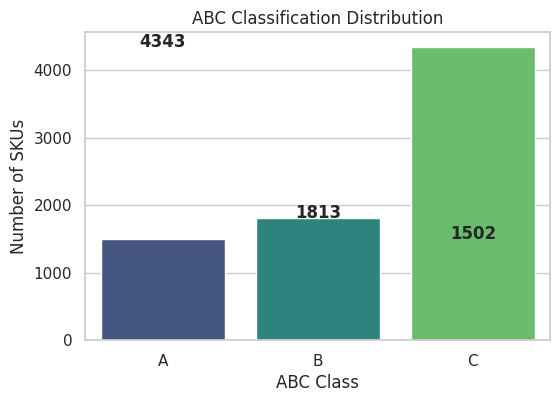

In [17]:
#ABC classification
plt.figure(figsize=(6,4))
abc_counts = abc_df['ABC'].value_counts()
sns.barplot(x=abc_counts.index, y=abc_counts.values, palette="viridis")
plt.title("ABC Classification Distribution")
plt.ylabel("Number of SKUs")
plt.xlabel("ABC Class")
for i, v in enumerate(abc_counts.values):
    plt.text(i, v + 1, str(v), ha='center', fontweight='bold')
plt.show()


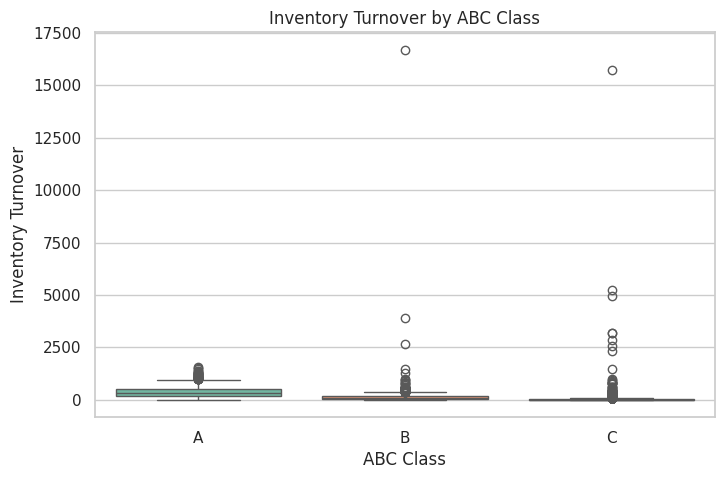

In [18]:
#inventory turnover by A/B/C class
plt.figure(figsize=(8,5))
sns.boxplot(x=product_perf['ABC'], y=product_perf['Turnover'], palette="Set2")
plt.title("Inventory Turnover by ABC Class")
plt.ylabel("Inventory Turnover")
plt.xlabel("ABC Class")
plt.show()


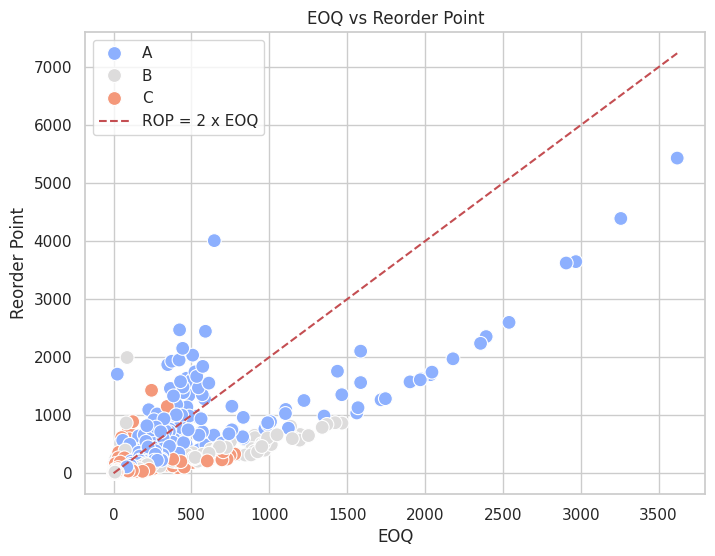

In [19]:
#EOQ vs ROP Scatter
plt.figure(figsize=(8,6))
sns.scatterplot(x=result['EOQ'], y=result['ReorderPoint'], hue=result['ABC'], palette="coolwarm", s=100)
plt.plot([0, result['EOQ'].max()], [0, result['EOQ'].max()*2], 'r--', label="ROP = 2 x EOQ")
plt.title("EOQ vs Reorder Point")
plt.xlabel("EOQ")
plt.ylabel("Reorder Point")
plt.legend()
plt.show()


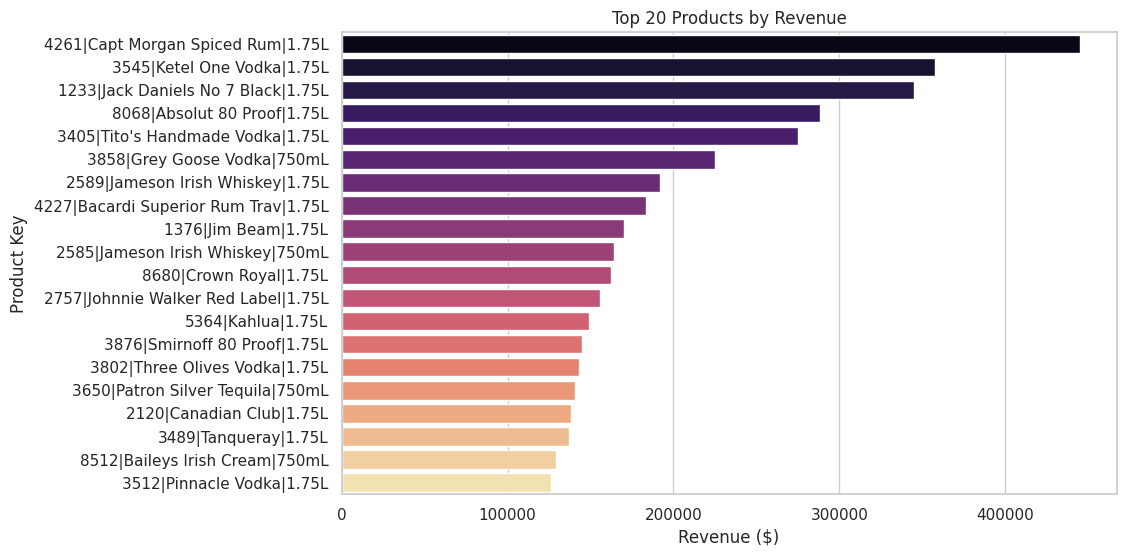

In [20]:
#Top Products Revenue Contribution
top_rev = top_performers.head(20)
plt.figure(figsize=(10,6))
sns.barplot(x=top_rev['Revenue'], y=top_rev.index, palette="magma")
plt.title("Top 20 Products by Revenue")
plt.xlabel("Revenue ($)")
plt.ylabel("Product Key")
plt.show()

In [21]:
#Supplier Lead Time Variability
import plotly.express as px

top_suppliers = supplier_perf.sort_values("TotalSpend", ascending=False).head(50)
fig = px.bar(
    top_suppliers,
    x="AvgLeadTime",
    y=top_suppliers.index,
    orientation='h',
    title="Top 50 Suppliers by Avg Lead Time",
    labels={"y":"Vendor Number", "AvgLeadTime":"Average Lead Time (days)"},
)
fig.show()




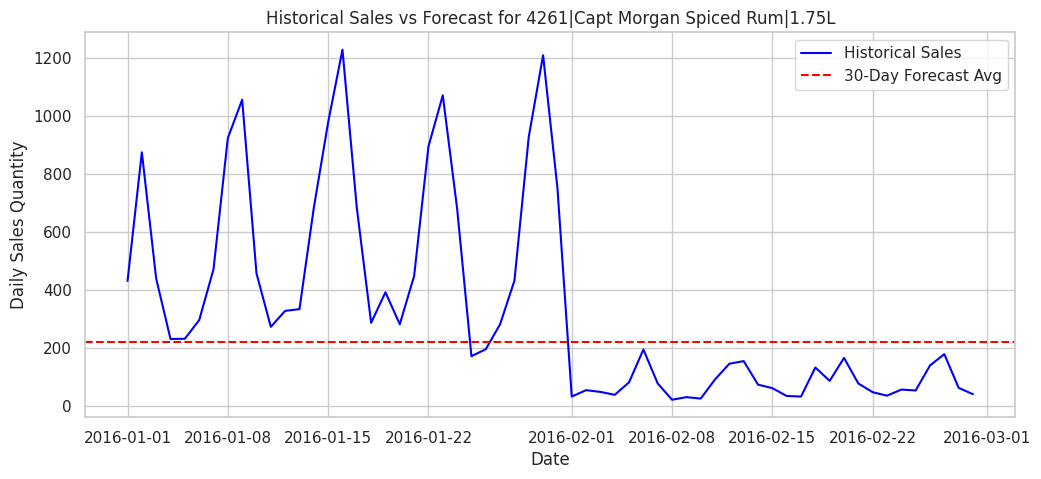

In [22]:
#example
#Forecast vs Historical Demand
example_product = top_products[0]
ts = sales[sales['ProductKey'] == example_product].set_index("SalesDate")["SalesQuantity"].resample("D").sum().fillna(0)
forecast_val = forecast_demand(example_product, periods=30) / 30  # avg daily forecast

plt.figure(figsize=(12,5))
plt.plot(ts.index, ts.values, label="Historical Sales", color="blue")
plt.axhline(forecast_val, color="red", linestyle="--", label="30-Day Forecast Avg")
plt.title(f"Historical Sales vs Forecast for {example_product}")
plt.xlabel("Date")
plt.ylabel("Daily Sales Quantity")
plt.legend()
plt.show()


In [23]:
# Merge product-level info
product_summary = result.copy()
product_summary = product_summary.reset_index()
product_summary['Brand'] = product_summary['ProductKey'].apply(lambda x: x.split('|')[0])
product_summary['Description'] = product_summary['ProductKey'].apply(lambda x: x.split('|')[1])
product_summary['Size'] = product_summary['ProductKey'].apply(lambda x: x.split('|')[2])

# Calculate Revenue per Unit for ranking
product_summary = product_summary.join(product_perf['RevenuePerUnit'], on='ProductKey')

# Sort by AnnualDemand and InventoryTurnover
product_summary_sorted = product_summary.sort_values(['AnnualDemand', 'InventoryTurnover'], ascending=[False, False])

print("\n========== PRODUCT-LEVEL SUMMARY ==========\n")
print(product_summary_sorted[['Brand', 'Description', 'Size', 'AnnualDemand', 'EOQ', 'ReorderPoint', 'InventoryTurnover', 'RevenuePerUnit']].head(10))



========== PRODUCT-LEVEL SUMMARY ==========

     Brand                   Description   Size  AnnualDemand     EOQ  \
6946  8111             Smirnoff 80 Proof   50mL       28544.0  3620.0   
1557  1892                    Yukon Jack   50mL       23121.0  3258.0   
5580  4261        Capt Morgan Spiced Rum  1.75L       20226.0   647.0   
4745  3606      Smirnoff Raspberry Vodka   50mL       19200.0  2969.0   
6200  5111  Dr McGillicuddy's Mentholmnt   50mL       18411.0  2907.0   
5078  3837                    Skyy Vodka   50mL       14057.0  2540.0   
5420  4135      Smirnoff Blueberry Vodka   50mL       12477.0  2393.0   
5449  4157    Smirnoff Green Apple Vodka   50mL       12102.0  2357.0   
4668  3545               Ketel One Vodka  1.75L       11883.0   424.0   
6925  8068              Absolut 80 Proof  1.75L       11189.0   444.0   

      ReorderPoint  InventoryTurnover  RevenuePerUnit  
6946        5433.0            1376.52        0.990000  
1557        4392.0            1193.17 